In [ ]:
!pip install cleverhans

     |████████████████████████████████| 92 kB 152 kB/s 
     |████████████████████████████████| 42 kB 766 kB/s 
     |████████████████████████████████| 154 kB 48.9 MB/s 


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
from torch.nn.functional import normalize

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import glob
import torch
from torch.utils.data import Dataset, DataLoader
from skimage import io

from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

import torchvision
from google.colab.patches import cv2_imshow
import cv2

from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import (
    projected_gradient_descent,
)
import matplotlib.pyplot as plt
import pandas as pd
import torchvision.models as models

In [ ]:
pretrained_model = models.vgg19(pretrained=True)

for param in pretrained_model.classifier[0].parameters():
    param.requires_grad = True

# pretrained_model_adv =  pretrained_model
print(pretrained_model)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

-------------------------------------------------- Class for Making custom dataset from image folder ------------------------------------------------------------

In [ ]:
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds = [0.229, 0.224, 0.225]
test_transforms = transforms.Compose([
                          # transforms.ToPILImage(),
                          transforms.ToTensor(),
                          transforms.Resize([224, 224]),
                           transforms.Normalize(mean=pretrained_means,
                                                std=pretrained_stds)])
data = torchvision.datasets.ImageFolder("/content/drive/MyDrive/IMAGENET/", transform  =  test_transforms)

In [ ]:
data[0][0].shape

torch.Size([3, 224, 224])

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
pretrained_model.classifier[0].in_features

25088

get all info from real images

In [ ]:
def get_data_real(dataset, a, b):
  # collect output of a layer https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/6
  activation = {}
  def get_activation(name):
      def hook(model, input, output):
          activation[name] = output.detach()
      return hook

  device = "cuda" if torch.cuda.is_available() else "cpu"

  # Evaluate on clean and adversarial data
  pretrained_model.eval().to(device)

  real_img = []
  activation_flat_real=[]
  predected_labels = []
  gradient_flat_real = []
  
  for i in trange(a, b):
    x, y = dataset[i]
    x = torch.unsqueeze(x, dim=0)
    x = x.to(device)
    
    print(x.shape)
    real_img.append(x)

    # collect output of flatten layer for real images
    pretrained_model.classifier[0].register_forward_hook(get_activation('flatten'))

    # give original image to the model
    y_pred = pretrained_model(x)  # model prediction on clean examples
    # print(y_pred)
    
    # flatten_avgpool = torch.flattten(activation['avgpool'])
    activation_flat_real.append(activation['flatten'])
    # activation['flatten'] = 0
    # print("activation",activation['flatten'])

    y_pred = F.softmax(y_pred, dim=-1) # column wise softmax
    # print(y_pred.shape)
    prob, y_class = y_pred.max(1)
    # print("Predected probability:",prob)
    
    # get gradient of flatten layer for real images
    prob.backward()  # https://www.tutorialspoint.com/what-does-backward-do-in-pytorch
        
    flatten_layer_grad_real = pretrained_model.classifier[0].weight.grad
    # print("grad shape before sum:",flatten_layer_grad_real.shape)
    
    # gradient for a single neuron
    flatten_layer_grad_real = flatten_layer_grad_real.sum(1)
    # flatten_grad = torch.flatten(flatten_layer_grad_real)
    gradient_flat_real.append(flatten_layer_grad_real)

    # print("grad shape after sum:", flatten_layer_grad_real.shape)
        # setting gradient 0 for next iteraton
    pretrained_model.classifier[0].weight.grad.data.zero_()
 
    predected_labels.append(y_class)

    # print("shape of activation:", len(activation_flat_real), len(activation_flat_real[0][0]))    

    # print("shape of grads:", len(gradient_flat_real), len(gradient_flat_real[0]))        

  real_img = torch.cat(real_img, dim=0)
  predected_labels = torch.cat(predected_labels, dim=0)
  activation_flat_real= torch.cat(activation_flat_real, dim=0)
  gradient_flat_real = torch.stack(gradient_flat_real)
  
  # plot images
  columns = 10 if (b-a)>10 else (b-a)
  rows = 1
  fig = plt.figure(figsize=(10,10))
  for i in range(1, columns*rows + 1):
      img = real_img[i-1].permute(1, 2, 0)
      img = img.cpu().detach().numpy()
      fig.add_subplot(rows, columns, i)
      plt.imshow(img)
  plt.show()
    # plt.savefig('dataset_and_generated_graph/same_resolution/plot'+str(i)+'.png', dpi=500, bbox_inches='tight')

  print("predected lebels: ", predected_labels)
  print("total size of the activation values in flatten layer: ", activation_flat_real.shape)
  print("total size of the gradient values in flatten layer: ", gradient_flat_real.shape)
  
  return real_img, predected_labels, activation_flat_real, gradient_flat_real

Perturbed image given to the model

In [ ]:
def get_data_adv_fgm(dataset, a, b):
  # collect output of a layer https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/6
  activation = {}
  def get_activation(name):
      def hook(model, input, output):
          activation[name] = output.detach()
      return hook

  device = "cuda" if torch.cuda.is_available() else "cpu"

  # Evaluate on clean and adversarial data
  pretrained_model.eval().to(device)

  activation_flat_adv=[]
  adv_img = []
  adv_labels = []
  gradient_flat_adv = []

  for i in trange(a, b):

        x, y = dataset[i]
        
        x = torch.unsqueeze(x, dim=0)
  
        x = x.to(device)
        # pertured images
        x_fgm = fast_gradient_method(pretrained_model, x, 0.8,2)
        adv_img.append(x_fgm)

        # x_fgm = projected_gradient_descent(pretrained_model, x, 0.3, 0.01, 50, 2)

        # collect output of flatten layer for adv images
        pretrained_model.classifier[0].register_forward_hook(get_activation('flatten_adv'))

        # setting gradient 0 for next iteraton
        pretrained_model.classifier[0].weight.grad.data.zero_()

        #  collect output of flatten layer for adv images
        y_pred_fgm = pretrained_model(x_fgm)  # model prediction on FGM adversarial examples
        activation_flat_adv.append(activation['flatten_adv'])
        # print(activation['flatten_adv'])

        y_pred_fgm = F.softmax(y_pred_fgm, dim=-1) # column wise softmax
        # print(y_pred_fgm.shape)
        prob_adv, y_class_adv = y_pred_fgm.max(1)
        print("Predected probability:",prob_adv)
      
        # get gradient of flatten layer for adv images
        prob_adv.backward()  # https://www.tutorialspoint.com/what-does-backward-do-in-pytorch
        
        flatten_layer_grad_adv = pretrained_model.classifier[0].weight.grad
        # print("grad shape before sum:",flatten_layer_grad_adv.shape)
        
        # gradient for a single neuron
        flatten_layer_grad_adv = flatten_layer_grad_adv.sum(1)
        gradient_flat_adv.append(flatten_layer_grad_adv)

        # print("grad shape after sum:", flatten_layer_grad_adv.shape)

        adv_labels.append(y_class_adv)

        # print("shape of activation:", len(activation_flat_adv), len(activation_flat_adv[0][0]))    

        # print("shape of grads:", len(gradient_flat_adv), len(gradient_flat_adv[0]))

  adv_img = torch.cat(adv_img, dim = 0)
  adv_labels = torch.cat(adv_labels, dim = 0)
  activation_flat_adv=torch.cat(activation_flat_adv, dim=0)
  gradient_flat_adv = torch.stack(gradient_flat_adv)

 # plot images
  columns = 10 if (b-a)>10 else (b-a)
  rows = 1
  fig = plt.figure(figsize=(10, 10))
  for i in range(1, columns*rows + 1):
      img = adv_img[i-1].permute(1, 2, 0)
      img = img.cpu().detach().numpy()
      fig.add_subplot(rows, columns, i)
      plt.imshow(img)
  plt.show()
    # plt.savefig('dataset_and_generated_graph/same_resolution/plot'+str(i)+'.png', dpi=500, bbox_inches='tight')

  print("predected lebels: ", adv_labels)
  print("total size of the activation values in flatten layer: ", activation_flat_adv.shape)
  print("total size of the gradient values in flatten layer: ", gradient_flat_adv.shape)

  return adv_img, adv_labels, activation_flat_adv, gradient_flat_adv

In [ ]:
def get_data_adv_targated(dataset, a, b):
  # collect output of a layer https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/6
  activation = {}
  def get_activation(name):
      def hook(model, input, output):
          activation[name] = output.detach()
      return hook

  device = "cuda" if torch.cuda.is_available() else "cpu"

  # Evaluate on clean and adversarial data
  pretrained_model.eval().to(device)

  activation_flat_adv=[]
  adv_img = []
  adv_labels = []
  gradient_flat_adv = []

  for i in trange(a, b):

        x, y = dataset[i]
        
        x = torch.unsqueeze(x, dim=0)
  
        x = x.to(device)
        # pertured images

        epsilon = 2./255

        delta = torch.zeros_like(x, requires_grad=True).to(device) #Gradient corresponding delta will be update during call to bckward() 
        opt = optim.SGD([delta], lr=1e-1)

        for t in range(30):
          pred = pretrained_model(x + delta)
          # print(pred)
          loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([22]).to(device))
          if t % 5 == 0:
            print(t, loss.item())
    
          opt.zero_grad()
          loss.backward() # Peforms dloss/ddelta
          opt.step()
          delta.data.clamp_(-epsilon, epsilon) # Limit the delta with norm ball of epsilon
 
        adv = x + delta

        # collect output of flatten layer for adv images
        pretrained_model.classifier[0].register_forward_hook(get_activation('flatten_adv'))

         # setting gradient 0 for next iteraton
        pretrained_model.classifier[0].grad.data.zero_()

        #  collect output of flatten layer for adv images
        y_pred_fgm = pretrained_model(adv)  # model prediction on FGM adversarial examples
        activation_flat_adv.append(activation['flatten_adv'])
        # print(activation['flatten_adv'])

        y_pred_fgm = F.softmax(y_pred_fgm, dim=-1) # column wise softmax
        # print(y_pred_fgm.shape)
        prob_adv, y_class_adv = y_pred_fgm.max(1)
        print("Predected probability:",prob_adv)
      
        # get gradient of flatten layer for adv images
        prob_adv.backward()  # https://www.tutorialspoint.com/what-does-backward-do-in-pytorch
        
        flatten_layer_grad_adv = pretrained_model.classifier[0].weight.grad
        # print("grad shape before sum:",flatten_layer_grad_adv.shape)
        
        # gradient for a single neuron
        flatten_layer_grad_adv = flatten_layer_grad_adv.sum(1)
        gradient_flat_adv.append(flatten_layer_grad_adv)

        # print("grad shape after sum:", flatten_layer_grad_adv.shape)

        adv_labels.append(y_class_adv)
        adv_img.append(adv)


        # print("shape of activation:", len(activation_flat_adv), len(activation_flat_adv[0][0]))    

        # print("shape of grads:", len(gradient_flat_adv), len(gradient_flat_adv[0]))

  adv_img = torch.cat(adv_img, dim = 0)
  adv_labels = torch.cat(adv_labels, dim = 0)
  activation_flat_adv=torch.cat(activation_flat_adv, dim=0)
  gradient_flat_adv = torch.stack(gradient_flat_adv)

 # plot images
  columns = 10 if (b-a)>10 else (b-a)
  rows = 1
  fig = plt.figure(figsize=(10, 10))
  for i in range(1, columns*rows + 1):
      img = adv_img[i-1].permute(1, 2, 0)
      img = img.cpu().detach().numpy()
      fig.add_subplot(rows, columns, i)
      plt.imshow(img)
  plt.show()
    # plt.savefig('dataset_and_generated_graph/same_resolution/plot'+str(i)+'.png', dpi=500, bbox_inches='tight')

  print("predected lebels: ", adv_labels)
  print("total size of the activation values in flatten layer: ", activation_flat_adv.shape)
  print("total size of the gradient values in flatten layer: ", gradient_flat_adv.shape)

  return adv_img, adv_labels, activation_flat_adv, gradient_flat_adv

In [ ]:
def plot_graphs(name, img_a, img_b,  neuron_a, neuron_b, sorted):

  X = list(int(i) for i in range(neuron_a, neuron_b))

  # Initialize the lists for X and Y

  fig, axs = plt.subplots(1, 2, figsize=(20,5))

  if name == 'act':
    axs[0].set_xlabel("Neurons")
    axs[0].set_ylabel("Activation")
    axs[1].set_xlabel("Neurons")
    axs[1].set_ylabel("Activation")
    if sorted:
      data1, indices = torch.sort(real_activation[img_a:img_b,neuron_a:neuron_b], descending=True, dim = 1)
    else:
      data1 = real_activation[img_a:img_b,neuron_a:neuron_b]
    data2 = adv_activation[img_a:img_b,neuron_a:neuron_b]
  
  elif name == 'grad':
    axs[0].set_xlabel("Neurons")
    axs[0].set_ylabel("Gradients")
    axs[1].set_xlabel("Neurons")
    axs[1].set_ylabel("Gradients")
    if sorted:
      data1, indices = torch.sort(real_grad[img_a:img_b,neuron_a:neuron_b], descending=True, dim = 1)
    else:
      data1 = real_grad[img_a:img_b,neuron_a:neuron_b]
    data2 = adv_grad[img_a:img_b,neuron_a:neuron_b]
  
  else:
    axs[0].set_xlabel("Neurons")
    axs[0].set_ylabel("Influence")
    axs[1].set_xlabel("Neurons")
    axs[1].set_ylabel("Influence")
    if sorted:
      data1, indices = torch.sort((real_activation[img_a:img_b,neuron_a:neuron_b]*real_grad[img_a:img_b,neuron_a:neuron_b]), descending=True, dim = 1)
    else:
      data1 = real_activation[img_a:img_b,neuron_a:neuron_b]*real_grad[img_a:img_b,neuron_a:neuron_b]
    data2 = adv_activation[img_a:img_b,neuron_a:neuron_b]*adv_grad[img_a:img_b,neuron_a:neuron_b]

  axs[0].grid()
  axs[1].grid()
  
  # select neurons
  if sorted:
    tmp = []
    for i in range(len(indices)):
      val = []
      for j in indices[i]:
        value = data2[i][j]
        val.append(value)
      tmp.append(torch.FloatTensor(val))
    data2 = tmp

  for i in range(img_b - img_a):
    
    axs[0].bar(X, data1[i].cpu(), color = 'g', width=2)
    axs[1].bar(X, data2[i].cpu(), color = 'r', width=2)

      # plt.savefig('dataset_and_generated_graph/same_resolution/plot'+str(i)+'.png', dpi=500, bbox_inches='tight')
  plt.show()

  print("neuron values")

  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


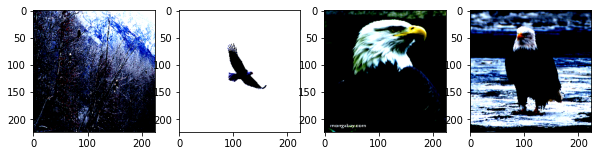

predected lebels:  tensor([972,  22,  22,  22])
total size of the activation values in flatten layer:  torch.Size([4, 4096])
total size of the gradient values in flatten layer:  torch.Size([4, 4096])


In [ ]:
real_img, real_lebels, real_activation, real_grad = get_data_real(data, 1, 5)

  0%|          | 0/4 [00:00<?, ?it/s]

Predected probability: tensor([0.2634], grad_fn=<MaxBackward0>)
Predected probability: tensor([0.4792], grad_fn=<MaxBackward0>)
Predected probability: tensor([0.9620], grad_fn=<MaxBackward0>)
Predected probability: tensor([0.9997], grad_fn=<MaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


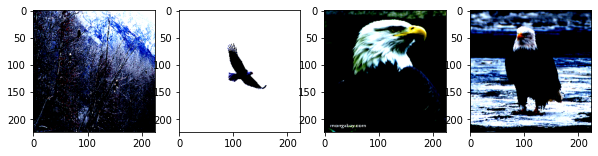

predected lebels:  tensor([677,  21,  22,  22])
total size of the activation values in flatten layer:  torch.Size([4, 4096])
total size of the gradient values in flatten layer:  torch.Size([4, 4096])


In [ ]:
adv_img, adv_lebel, adv_activation, adv_grad = get_data_adv_fgm(data, 1, 5) 

In [ ]:
print("predected classes on real images", real_lebels)
print("predected classes on adv images", adv_lebel)

predected classes on real images tensor([972,  22,  22,  22])
predected classes on adv images tensor([677,  21,  22,  22])


In [ ]:
real_activation[:,0:1000].shape

torch.Size([4, 1000])

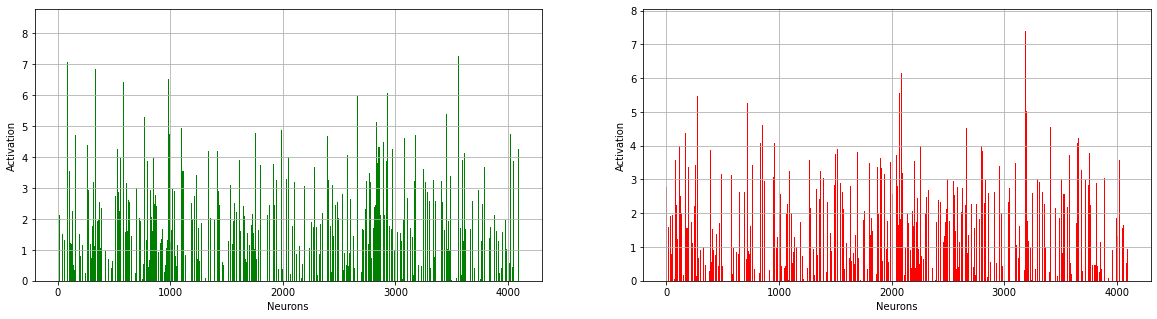

neuron values


In [ ]:
plot_graphs('act', 1, 2, 0, 4096, False)

Neuron Selection

In [ ]:
def neuron_selection_module(activation, grad):

  inf = activation * grad
  # print(real_inf)
  sorted, ind = torch.sort(inf, descending=True, dim =1 )
  
  total_neurons = ind.shape[1]
  
  front_neurons = ind[:,:int(total_neurons*.1)+1]
  print("front neurons:", front_neurons.shape)
  
  middle_neurons = ind[:,int(total_neurons*.1)+1:int(total_neurons*.3)+1]
  print("middle neurons:", middle_neurons.shape)
  
  tail_neurons = ind[:,int(total_neurons*.3)+1:]
  print("tail neurons:", tail_neurons.shape)

  return front_neurons, middle_neurons, tail_neurons

In [ ]:
front_neurons, middle_neurons, tail_neurons = neuron_selection_module(real_activation, real_grad)

front neurons: torch.Size([4, 410])
middle neurons: torch.Size([4, 819])
tail neurons: torch.Size([4, 2867])


Similarity Measurement

In [ ]:
middle = middle_neurons[0].cpu()
for i in range(1, len(middle_neurons)):
  middle = np.intersect1d(middle, middle_neurons[i].cpu())
print(middle.shape)

front = front_neurons[0].cpu()
for i in range(1, len(front_neurons)):
  front = np.intersect1d(front, front_neurons[i].cpu())
print(front.shape)

tail = tail_neurons[0].cpu()
for i in range(1, len(tail_neurons)):
  tail = np.intersect1d(tail, tail_neurons[i].cpu())
print(tail.shape)

(191,)


Loss

In [ ]:
def total_loss(front_neurons, tail_neurons, activation):
  
  # Total loss of front neurons
  front_inf = []
  for i in range(len(front_neurons)):
      val = []
      for j in front_neurons[i]:
          value = activation[i][j]
          val.append(value)
      front_inf.append(torch.FloatTensor(sum(val)))
  print("Loss of front neurons:",front_inf)

  # Total loss of tail neurons
  tail_inf = []
  for i in range(len(tail_neurons)):
      val = []
      for j in tail_neurons[i]:
          value = activation[i][j]
          val.append(value)
      tail_inf.append(torch.FloatTensor(sum(val)))
  print("Loss of tail neurons:", tail_inf)

  # Subtract two lists with numpy
  array1 = np.array(front_inf)
  array2 = np.array(tail_inf)
  
  subtracted_array = np.subtract(array1, array2)
  x = []
  for i in subtracted_array:
    x.append([int(abs(i))])
  subtracted_array = torch.LongTensor(x)

  print("total loss(front - tail):\n", subtracted_array)

  return subtracted_array

In [ ]:
neuron_loss = total_loss(front_neurons, tail_neurons, real_activation)

Loss of front neurons: [tensor(547.6802), tensor(1141.9756), tensor(1556.3121), tensor(1851.2955)]
Loss of tail neurons: [tensor(629.8754), tensor(1172.5243), tensor(965.8370), tensor(1088.2213)]
total loss(front - tail):
 tensor([[ 82],
        [ 30],
        [590],
        [763]])


In [ ]:
def perturbation(real_img, neuron_loss):
  grad = []
  for i in range(len(real_img)):
    im = torch.unsqueeze(real_img[i],dim=0)
    im.requires_grad=True
    pred = pretrained_model(im)

    loss = nn.CrossEntropyLoss()(pred, neuron_loss[i])
    print(loss)
    loss.backward()
    grad.append(im.grad)

  grad = torch.cat(grad, dim=0)
  print("purturbation shape:", grad.shape)
  return grad

In [ ]:
grad = perturbation(real_img, neuron_loss)

tensor(9.6679, grad_fn=<NllLossBackward0>)
tensor(28.5358, grad_fn=<NllLossBackward0>)
tensor(37.1711, grad_fn=<NllLossBackward0>)
tensor(44.4807, grad_fn=<NllLossBackward0>)
purturbation shape: torch.Size([4, 3, 224, 224])


In [ ]:
def show_images(real_img, grad, img_a, img_b):
  def_img = []
  for i in range(len(real_img)):
    def_img.append(real_img[i] + grad[i])

  f, arr = plt.subplots((img_b - img_a), 3, figsize=(15, 15))
  for i in range(img_a, img_b):
      arr[i-img_a, 0].imshow(real_img[i].permute(1, 2, 0))
      arr[i-img_a, 1].imshow(def_img[i].permute(1, 2, 0))
      arr[i-img_a, 2].imshow(grad[i].permute(1, 2, 0))
  plt.show()
  return def_img


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


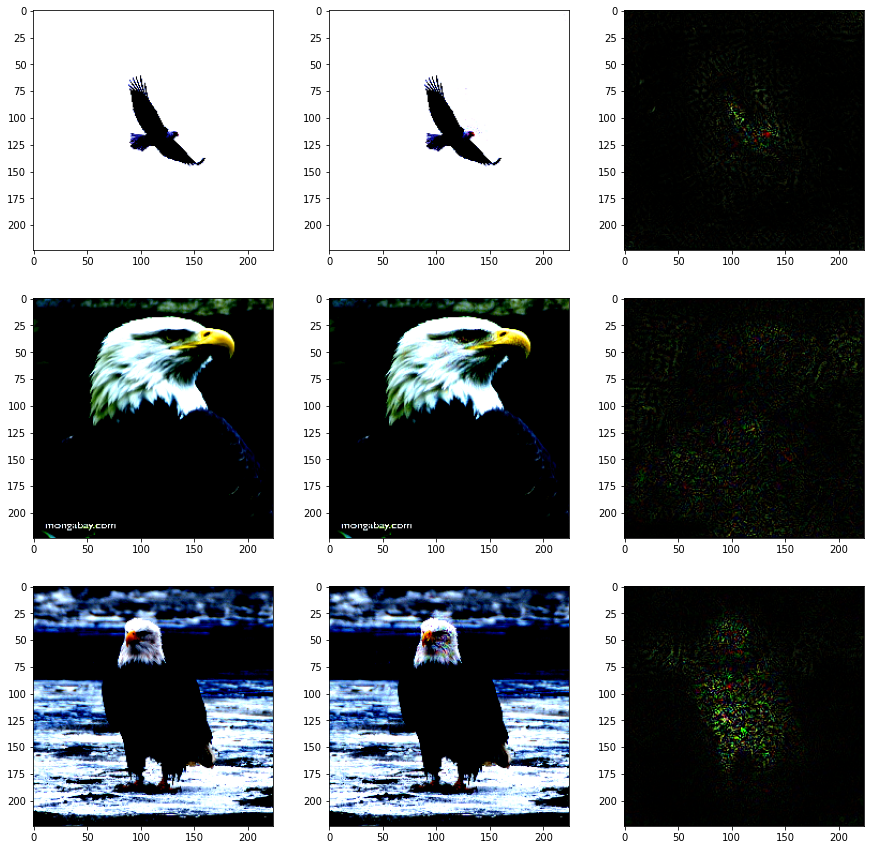

In [ ]:
def_img = show_images(real_img, grad, 1, 4)

In [ ]:
pred = pretrained_model(torch.unsqueeze(real_img[0], dim=0))
prob = F.softmax(pred, dim=-1)
c, p = prob.max(1)

pred1 = pretrained_model(torch.unsqueeze(def_img[0], dim=0))
prob1 = F.softmax(pred1, dim=-1)
c1, p1 = prob1.max(1)

In [ ]:
print(c, c1)

tensor([0.2139], grad_fn=<MaxBackward0>) tensor([0.6788], grad_fn=<MaxBackward0>)


In [ ]:
print(p, p1)

tensor([972]) tensor([483])


In [ ]:
import torchvision

In [ ]:
def get_data_adv_test1(dataset, a, b):
  # collect output of a layer https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/6
  activation = {}
  def get_activation(name):
      def hook(model, input, output):
          activation[name] = output.detach()
      return hook

  device = "cuda" if torch.cuda.is_available() else "cpu"

  # Evaluate on clean and adversarial data
  pretrained_model.eval().to(device)

  for i in trange(a, b):

        x, y = dataset[i]
        
        x = torch.unsqueeze(x, dim=0)
  
        x = x.to(device)
        # pertured images
        x_fgm = fast_gradient_method(pretrained_model, x, 0.8,2)

        # collect output of flatten layer for adv images
        pretrained_model.classifier[0].register_forward_hook(get_activation('flatten_adv'))
        flatten = pretrained_model(x_fgm)
        
        print(activation['flatten_adv'], activation['flatten_adv'].shape)

        with open('output.txt', 'a') as f:
          f.write(str(activation['flatten_adv']))
          f.write('\n')
        return activation['flatten_adv']

In [ ]:
def get_data_adv_test2(dataset, a, b):
  # collect output of a layer https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/6
  
  device = "cuda" if torch.cuda.is_available() else "cpu"

  # Evaluate on clean and adversarial data
  pretrained_model.eval().to(device)

  for i in trange(a, b):

        x, y = dataset[i]
        
        x = torch.unsqueeze(x, dim=0)
  
        x = x.to(device)
        # pertured images
        # x_fgm = fast_gradient_method(pretrained_model, x, 0.8,2)

        avg_pool = torchvision.models._utils.IntermediateLayerGetter(pretrained_model, return_layers={'classifier':'avgpool'})
        
        #  collect output of flatten layer for adv images
        avgpool = avg_pool(x)  # model prediction on FGM adversarial example
        # flatten = torch.flatten(avgpool['avgpool'])

        # flatten_out = torchvision.models._utils.IntermediateLayerGetter(pretrained_model.classifier, return_layers={'0':'flatten'})        
        # flatten = flatten_out(flatten)
        
        print(avgpool['avgpool'],avgpool['avgpool'].shape)

        # with open('output.txt', 'a') as f:
        #   f.write(str(avgpool['avgpool']))
        #   f.write('\n')
        # return avgpool['avgpool']
b = get_data_adv_test2(data, 3, 4)

  0%|          | 0/1 [00:00<?, ?it/s]

RuntimeError: ignored

In [ ]:

# c = b.reshape(-1)

  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.5042, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 2

In [ ]:
c.shape

torch.Size([25088])

In [ ]:
# for p in flatten_output.parameters():
a = get_data_adv_test1(data, 3, 4)
b = get_data_adv_test1(data, 3, 4)

  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[0.0000, 8.1170, 3.4094,  ..., 0.0000, 0.0000, 0.0000]]) torch.Size([1, 4096])


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[0.0000, 8.1170, 3.4094,  ..., 0.0000, 0.0000, 0.0000]]) torch.Size([1, 4096])


In [ ]:
output = pretrained_model.classifier[1](a)
output =  pretrained_model.classifier[3](output)
output =  pretrained_model.classifier[4](output)
output =  pretrained_model.classifier[6](output)

In [ ]:
print((output))

In [ ]:
output1 = pretrained_model.classifier[1](b)
output1 =  pretrained_model.classifier[3](output1)
output1 =  pretrained_model.classifier[4](output1)
output1 =  pretrained_model.classifier[6](output1)

In [ ]:
print((output1))

In [ ]:
normalized = torch.nn.functional.normalize(adv_activation, p=2.0, dim=1)
print(normalized)

tensor([[0.0000, 0.0000, 0.0032,  ..., 0.0380, 0.0000, 0.0421]],
       device='cuda:0')


In [ ]:
sorted = torch.sort(normalized, descending = True, dim=1)
print(sorted)

torch.return_types.sort(
values=tensor([[0.1598, 0.1363, 0.1178,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0'),
indices=tensor([[  37, 2370, 3494,  ..., 4089, 4090, 4094]], device='cuda:0'))


In [ ]:
2./255

0.00784313725490196